In [1]:
import os

os.environ['QT_API'] = 'pyside'
%matplotlib inline  

In [2]:
# QSTK Imports
import QSTK.qstkutil.qsdateutil as du
import QSTK.qstkutil.tsutil as tsu
import QSTK.qstkutil.DataAccess as da

# Third Party Imports
import datetime as dt
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [3]:
    # Reading the portfolio
    na_portfolio = np.loadtxt('tutorial3portfolio.csv', dtype='S5,f4',
                        delimiter=',', comments="#", skiprows=1)
    print na_portfolio

[('SPY', 0.30000001192092896) ('GABBA', 0.20000000298023224)
 ('GLD', 0.30000001192092896) ('7ABBA', 0.20000000298023224)]


In [11]:
    # Sorting the portfolio by symbol name
    na_portfolio = sorted(na_portfolio, key=lambda x: x[0])
    print na_portfolio

[('7ABBA', 0.20000000298023224), ('GABBA', 0.20000000298023224), ('GLD', 0.30000001192092896), ('SPY', 0.30000001192092896)]


In [15]:
print na_portfolio[0][1]

type(na_portfolio[0])

0.2


numpy.void

In [16]:
    # Create two list for symbol names and allocation
    ls_port_syms = []
    lf_port_alloc = []
    for port in na_portfolio:
        ls_port_syms.append(port[0])
        lf_port_alloc.append(port[1])

In [17]:
    # Creating an object of the dataaccess class with Yahoo as the source.
    c_dataobj = da.DataAccess('Yahoo')
    ls_all_syms = c_dataobj.get_all_symbols()


In [22]:
    # Bad symbols are symbols present in portfolio but not in all syms
    ls_bad_syms = list(set(ls_port_syms) - set(ls_all_syms))

    if len(ls_bad_syms) != 0:
        print "Portfolio contains bad symbols : ", ls_bad_syms

    for s_sym in ls_bad_syms:
        i_index = ls_port_syms.index(s_sym)
        ls_port_syms.pop(i_index)
        lf_port_alloc.pop(i_index)

Portfolio contains bad symbols :  ['7ABBA', 'GABBA']


In [23]:
    # Reading the historical data.
    dt_end = dt.datetime(2011, 1, 1)
    dt_start = dt_end - dt.timedelta(days=1095)  # Three years
    # We need closing prices so the timestamp should be hours=16.
    dt_timeofday = dt.timedelta(hours=16)

    # Get a list of trading days between the start and the end.
    ldt_timestamps = du.getNYSEdays(dt_start, dt_end, dt_timeofday)

In [24]:
    # Keys to be read from the data, it is good to read everything in one go.
    ls_keys = ['open', 'high', 'low', 'close', 'volume', 'actual_close']

    # Reading the data, now d_data is a dictionary with the keys above.
    # Timestamps and symbols are the ones that were specified before.
    ldf_data = c_dataobj.get_data(ldt_timestamps, ls_port_syms, ls_keys)
    d_data = dict(zip(ls_keys, ldf_data))


In [31]:
    # Copying close price into separate dataframe to find rets
    df_rets = d_data['close'].copy()
    # Filling the data.
    df_rets = df_rets.fillna(method='ffill')
    df_rets = df_rets.fillna(method='bfill')
    df_rets = df_rets.fillna(1.0)

    # Numpy matrix of filled data values
    na_rets = df_rets.values

In [33]:
na_rets.shape

(757L, 2L)

In [34]:
    # returnize0 works on ndarray and not dataframes.
    tsu.returnize0(na_rets)

array([[ 0.        ,  0.        ],
       [ 0.00836672, -0.00045403],
       [-0.00514199, -0.02452873],
       ..., 
       [ 0.00357091,  0.00073728],
       [-0.00493791, -0.00155534],
       [ 0.01233307,  0.00024596]])

In [35]:
    # Estimate portfolio returns
    na_portrets = np.sum(na_rets * lf_port_alloc, axis=1)
    na_port_total = np.cumprod(na_portrets + 1)
    na_component_total = np.cumprod(na_rets + 1, axis=0)

In [37]:
na_portrets.shape

(757L,)

In [40]:
na_port_total.shape

(757L,)

In [41]:
na_component_total.shape

(757L, 2L)

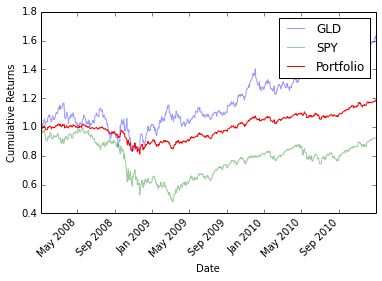

In [42]:
    # Plotting the results
    plt.clf()
    fig = plt.figure()
    fig.add_subplot(111)
    plt.plot(ldt_timestamps, na_component_total, alpha=0.4)
    plt.plot(ldt_timestamps, na_port_total)
    ls_names = ls_port_syms
    ls_names.append('Portfolio')
    plt.legend(ls_names)
    plt.ylabel('Cumulative Returns')
    plt.xlabel('Date')
    fig.autofmt_xdate(rotation=45)
    plt.show()
    